# 20 Newsgroups Dataset
## Dr. Omri Allouche, Gong.io, Bar Ilan University

The dataset is included in scikit learn. Downloading it might require some time.  
Scikit learn provides helper methods to fetch the data.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train')
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [4]:
print(newsgroups_train.filenames.shape)
print(newsgroups_train.target.shape)
print(newsgroups_train.target[:10])

(11314,)
(11314,)
[ 7  4  4  1 14 16 13  3  2  4]


For this exercise, we will use only some of the groups - `rec.sport.baseball`, `rec.sport.hockey`, `talk.politics.guns`, `talk.politics.mideast`.  
We will also get only the post text, and remove its header information.

In [123]:
newsgroups_categories = ['rec.sport.baseball', 'rec.sport.hockey', 'talk.politics.guns', 'talk.politics.mideast']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=newsgroups_categories,
                                      remove=('headers', 'footers', 'quotes'))

We can see below that we have roughly 580 documents in each class:

In [3]:
pd.Series(newsgroups_train.target).value_counts()

1    600
0    597
3    564
2    546
dtype: int64

In [17]:
df['doc_len'] = df['data'].str.len()

In [18]:
df.head()

,data,target,target_name,doc_len
0,Does anyone have the scoop on Scot Erickson? ...,0,rec.sport.baseball,83
1,\nNot particularly *in* the World Series. Duri...,0,rec.sport.baseball,3094
2,\nI think the three-headed GM's guiding princi...,1,rec.sport.hockey,944
3,\n\n\nA suggestion: cameras panning over plant...,2,talk.politics.guns,153
4,\nDon't you Americans study history...the Fren...,1,rec.sport.hockey,201


(0, 5000)

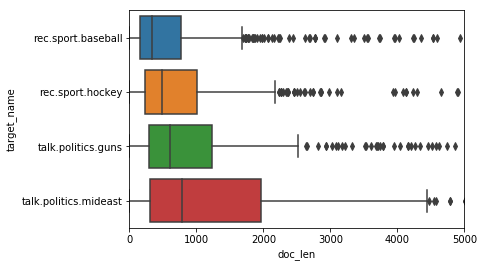

In [24]:
sns.boxplot(data=df, y='target_name', x='doc_len')
plt.xlim(0,5000)

Now let's fit a Tf-Idf vectorizer to these documents. We'll remove English stopwords, and check the words that have the highest Tfidf score for each class:

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2307, 30248)

In [105]:
df['tfidf'] = list(vectors.toarray())

In [119]:
inverse_vocab = {v: k for k,v in vectorizer.vocabulary_.items()}
top_terms = df.groupby('target_name')['tfidf'].apply(lambda x: x.sum(axis=0))
for i,r in top_terms.iteritems():
    print(i)
    print([inverse_vocab[x] for x in np.argsort(r)[-20:][::-1]])
    print()

rec.sport.baseball
['year', 'baseball', 'team', 'game', 'runs', 'games', 'think', 'hit', 'good', 'pitching', 'braves', 'don', 'just', 'players', 'like', 'win', 'know', 'time', 'season', 'ball']

rec.sport.hockey
['game', 'team', 'hockey', 'play', 'games', 'players', 'season', 'nhl', 'year', 'think', 'don', 'like', 'just', 'detroit', 'good', 'leafs', 'league', 'teams', 'playoffs', 'pittsburgh']

talk.politics.guns
['gun', 'people', 'guns', 'don', 'fbi', 'weapons', 'just', 'law', 'government', 'right', 'think', 'like', 'know', 'firearms', 'com', 'use', 'batf', 'police', 'make', 'crime']

talk.politics.mideast
['israel', 'israeli', 'jews', 'people', 'armenian', 'armenians', 'turkish', 'arab', 'just', 'said', 'jewish', 'arabs', 'turkey', 'like', 'peace', 'don', 'know', 'did', 'war', 'say']



### Basic Classifier
Next, let's build a basic classifier. Let's use the Multinomial Naive Bayes:

In [185]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=newsgroups_categories)
vectors_test = vectorizer.transform(newsgroups_test.data)
clf = MultinomialNB()
clf.fit(vectors, newsgroups_train.target)

y_truth = newsgroups_test.target
y_predict_proba = clf.predict_proba(vectors_test)
y_predict = clf.predict(vectors_test)

In [186]:
metrics.f1_score(y_truth, y_predict, average='macro')

0.893119327249776

We see that even a simple model performs pretty well. Let's examine the most important features for each class:

In [187]:
def show_top_terms(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top_terms = np.argsort(classifier.coef_[i])[-20:]
        print(category)
        print(", ".join(feature_names[top_terms]))
        print()

show_top_terms(clf, vectorizer, newsgroups_train.target_names)

rec.sport.baseball
ball, season, time, know, win, like, players, just, don, braves, pitching, good, hit, think, games, runs, game, team, baseball, year

rec.sport.hockey
pittsburgh, playoffs, teams, league, leafs, good, detroit, just, like, don, think, year, nhl, season, players, games, play, hockey, team, game

talk.politics.guns
crime, make, police, batf, use, com, firearms, know, like, think, right, government, law, just, weapons, fbi, don, guns, people, gun

talk.politics.mideast
say, war, did, know, don, peace, like, turkey, arabs, jewish, said, just, arab, turkish, armenians, armenian, people, jews, israeli, israel



Let's further examine the classification report and the confusion matrix:

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
# import copy
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


def plot_roc_curve( y_predict_proba, y_truth):
    y_score = np.array(y_predict_proba)
    if len(y_truth.shape) == 1:
        dummies = pd.get_dummies(y_truth)
        y_dummies = dummies.values
    else:
        y_dummies = y_truth

    y_classes = dummies.columns

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    for i, class_name in enumerate(y_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_dummies.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    for i, class_name in enumerate(y_classes):
        plt.plot(fpr[i], tpr[i],
                 lw=lw, label='%s (area = %0.2f)' % (class_name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # threshold for positive class
    ax2 = plt.gca().twinx()
    ax2.plot(fpr[1], thresholds[1], markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold')
    ax2.set_ylim([thresholds[1][-1], thresholds[1][0]])
    ax2.set_xlim([fpr[1][0], fpr[1][-1]])

    # plt.show()
    return plt.gcf()


def plot_precision_recall_curve(  y_predict_proba, y_truth):
    y_score = np.array(y_predict_proba)
    if len(y_truth.shape) == 1:
        dummies = pd.get_dummies(y_truth)
        y_dummies = dummies.values
    else:
        y_dummies = y_truth

    y_classes = dummies.columns
    for i, class_name in enumerate(y_classes):
        precision, recall, thresholds = precision_recall_curve(y_dummies[:, i], y_score[:, i])

        plt.step(recall, precision,
                 label=class_name,
                 lw=2,
                 where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")

    # ax2 = plt.gca().twinx()
    # ax2.plot(recall[1:], thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    # ax2.set_ylabel('Threshold')

    # plt.show()
    return plt.gcf()


def plot_confidence_performance(y_predict, y_predict_proba, y_truth, num_bins=20):
    predicted_probabilities = np.max(y_predict_proba, axis=1)
    is_correct = (y_truth == y_predict)
    ax = sns.regplot(x=predicted_probabilities, y=is_correct, x_bins=num_bins)
    plt.xlabel('Model Confidence')
    plt.ylabel('Average accuracy')
    # plt.show()
    return plt.gcf()


In [189]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if classes is not None:
        # Only use the labels that appear in the data
        classes = [classes[x] for x in unique_labels(y_true, y_pred)]
    else:
        classes = unique_labels(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig


def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth

    # Begin CHANGES
    fst_empty_cell = (columnwidth - 3) // 2 * " " + "t/p" + (columnwidth - 3) // 2 * " "

    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES

    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")

    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()


In [190]:
newsgroups_test.target_names

['rec.sport.baseball',
 'rec.sport.hockey',
 'talk.politics.guns',
 'talk.politics.mideast']

In [191]:
from sklearn import metrics
print(metrics.classification_report(y_truth, y_predict, target_names=newsgroups_test.target_names))

                       precision    recall  f1-score   support

   rec.sport.baseball       0.95      0.86      0.90       397
     rec.sport.hockey       0.84      0.95      0.89       399
   talk.politics.guns       0.89      0.87      0.88       364
talk.politics.mideast       0.90      0.90      0.90       376

            micro avg       0.89      0.89      0.89      1536
            macro avg       0.90      0.89      0.89      1536
         weighted avg       0.90      0.89      0.89      1536



Normalized confusion matrix
[[0.85642317 0.11083123 0.01511335 0.01763224]
 [0.01754386 0.94736842 0.02255639 0.01253133]
 [0.01923077 0.0467033  0.86813187 0.06593407]
 [0.00797872 0.02659574 0.06648936 0.89893617]]


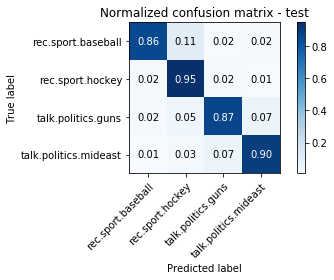

In [192]:
plot_confusion_matrix(y_truth, y_predict, classes=newsgroups_test.target_names, normalize=True, title='Normalized confusion matrix - test');

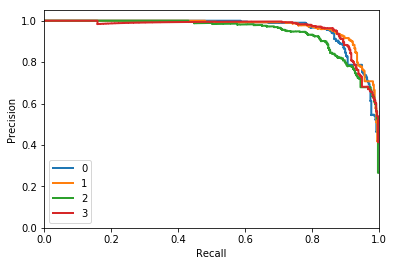

In [193]:
plot_precision_recall_curve(y_predict_proba, y_truth);

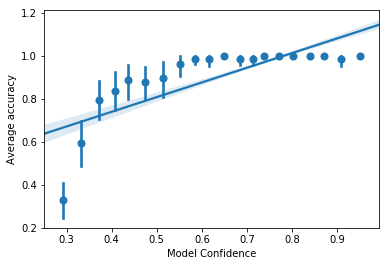

In [194]:
plot_confidence_performance(y_predict, y_predict_proba, y_truth, num_bins=20);

Next, let's perform an error analysis and manually review documents that are wrongly classified. We will focus on documents that have a high model confidence:

In [200]:
df_test = pd.DataFrame({
    'data': newsgroups_test.data,
    'target': newsgroups_test.target,
    'target_name': [newsgroups_test.target_names[x] for x in newsgroups_test.target],
    'y_truth': y_truth,
    'y_predict': y_predict
})

In [201]:
df_test['is_error'] = y_predict != y_truth

In [202]:
def print_document(i,r):
    
    print('Document #{}. True label: {}. Predicted: {} (confidence: {:.1}%)'.format(
        i,
        r['target_name'], 
        newsgroups_test.target_names[ r['y_predict'] ],
        0.5
    ))
    print()
    print(r['data'])

In [205]:
df_test['doc_len'] = df_test['data'].str.len()

In [203]:
df_test.sort_values('is_error', ascending=False).head()

,data,target,target_name,y_truth,y_predict,is_error
1535,\n I'd have to agree with you there Joe.,2,talk.politics.guns,2,1,True
1219,"\nWell, it seems we don't learn the lessons of...",2,talk.politics.guns,2,3,True
380,,0,rec.sport.baseball,0,1,True
379,"\n\n\nGood question. It's my impression, not ...",0,rec.sport.baseball,0,2,True
376,Again I assume this is not just flame bait by ...,1,rec.sport.hockey,1,2,True


In [204]:
print_document('578', df_test.loc[1535])

Document #578. True label: talk.politics.guns. Predicted: rec.sport.hockey (confidence: 0.5%)

 
  I'd have to agree with you there Joe.


In [176]:
newsgroups_test.target_names[ df_test.loc[578]['y_predict'] ]

'rec.sport.hockey'

In [209]:
df_test.head()

,data,target,target_name,y_truth,y_predict,is_error,doc_len
0,"[snip]....\n\n\n\n\n\n\n\n\n\tExcellent point,...",2,talk.politics.guns,2,2,False,677
1,Ugliest swing..I am not sure. I think the ugli...,0,rec.sport.baseball,0,0,False,190
2,Do the Isles have another defenseman to insert...,1,rec.sport.hockey,1,1,False,817
3,This comes indirectly from Al Morgani who work...,1,rec.sport.hockey,1,1,False,704
4,Team Canada defeated Russia 3-1 to finish the ...,1,rec.sport.hockey,1,1,False,491


(0, 5000)

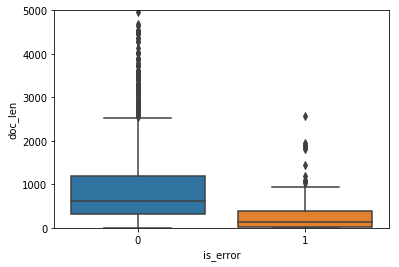

In [213]:
sns.boxplot(data=df_test, x=df_test['is_error'].astype(int), y='doc_len')
plt.ylim(0,5000)